In [1]:
%matplotlib inline
import numpy as np
import openmc

In [2]:
#create materials

#fuel
fuel = openmc.Material(1, "Am242m")
fuel.add_nuclide('Am242_m1',1)
fuel.set_density('g/cm3',13.6)
print(fuel)

#moderator
BeO = openmc.Material(2, "BeO")
BeO.add_nuclide("Be9", .5)
BeO.add_nuclide("O16", .5)
BeO.set_density("g/cm3", 2.86)
print(BeO)

#"vacuum"
vac = openmc.Material(3, "H1")
vac.add_nuclide('H1',1.0)
vac.set_density('g/cm3',0.000001)
print(vac)

#reflector
#may add a reflector in the future. for now just BeO moderator

Material
	ID             =	1
	Name           =	Am242m
	Temperature    =	None
	Density        =	13.6 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Am242_m1       =	1            [ao]

Material
	ID             =	2
	Name           =	BeO
	Temperature    =	None
	Density        =	2.86 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	Be9            =	0.5          [ao]
	O16            =	0.5          [ao]

Material
	ID             =	3
	Name           =	H1
	Temperature    =	None
	Density        =	1e-06 [g/cm3]
	S(a,b) Tables  
	Nuclides       
	H1             =	1.0          [ao]



In [3]:
# Outer radius of fuel
fuel_outer = 1 #1 cm fuel outer radius
fuel_thickness = 1e-3
fuel_inner = fuel_outer - fuel_thickness #inner radius for 2micron fuel layer

# parameters for depth of various things
fuel_depth = 30 #depth of fuel/moderator disk
ref_depth = 10 #depth of top reflecting/moderating layer

#edge length of hexagonal fuel cell
mod_thickness = 5
hex_dis = fuel_outer + mod_thickness
edge = hex_dis * 2 / np.sqrt(3)

#outer radius of fuel disk
disk_outer = 50 # radius in cm

In [4]:
#define a cell surface for a single fuel cylinder
f_inner_surf = openmc.ZCylinder(R=fuel_inner, boundary_type="transmission")
f_outer_surf = openmc.ZCylinder(R=fuel_outer, boundary_type="transmission")
f_lower_surf = openmc.ZPlane(z0=0, boundary_type="vacuum")
f_upper_surf = openmc.ZPlane(z0=fuel_depth, boundary_type="transmission")
m_upper_surf = openmc.ZPlane(z0=fuel_depth+ref_depth, boundary_type="vacuum")

outer_bound = openmc.ZCylinder(R=disk_outer+2*hex_dis, boundary_type="vacuum")

hex_region = openmc.get_hexagonal_prism(edge_length=edge, orientation='x', boundary_type="transmission")
periodic_hex = openmc.get_hexagonal_prism(edge_length=edge, orientation='x', boundary_type="periodic")

fuel_region = -f_outer_surf & +f_inner_surf & -f_upper_surf & +f_lower_surf
mod_region = +f_outer_surf & -f_upper_surf & + f_lower_surf & hex_region
vac_region = -f_inner_surf & +f_lower_surf & -f_upper_surf

hex_mod = +f_upper_surf & -m_upper_surf & hex_region
hex_edge = +f_lower_surf & -m_upper_surf & hex_region

mod_region_per = +f_outer_surf & -f_upper_surf & + f_lower_surf & periodic_hex
hex_mod_per = +f_upper_surf & -m_upper_surf & periodic_hex

#fill the fuel region
f=openmc.Cell(1, 'fuel')
f.fill=fuel
f.region=fuel_region

#fill the moderator regions
m = openmc.Cell(2, 'moderator region 1')
m.fill=BeO
m.region=mod_region

m_per = openmc.Cell(2, 'moderator region 1 periodic')
m_per.fill=BeO
m_per.region=mod_region_per

m2 = openmc.Cell(3, 'top hex moderator')
m2.fill=BeO
m2.region=hex_mod

m2_per = openmc.Cell(3, 'top hex moderator periodic')
m2_per.fill=BeO
m2_per.region=hex_mod_per

medge = openmc.Cell(4, 'full plug hex')
medge.fill = BeO
medge.region = hex_edge

v = openmc.Cell(5, 'vacuum')
v.fill = vac
v.region = vac_region

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


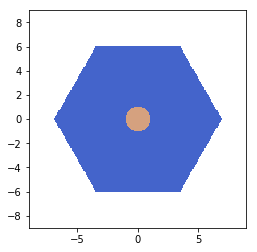

In [5]:
#visualize the fuel geometry
f_univ = openmc.Universe(cells=[f, m, m2, v])
f_univ.plot(width=(3*hex_dis, 3*hex_dis), origin = (0,0,fuel_depth/2), basis='xy')

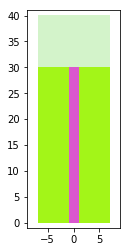

In [6]:
f_univ.plot(width=(3*hex_dis, fuel_depth+ref_depth+2), origin = (0, 0, (fuel_depth+ref_depth)/2), basis='xz')

In [7]:
edge_plug = openmc.Universe(cells=[medge])
#edge_plug.plot(width=(3*hex_dis, 3*hex_dis), origin = (0,0,fuel_depth/2), basis='xy')

In [8]:
#edge_plug.plot(width=(3*hex_dis, fuel_depth+ref_depth+2), origin = (0, 0, (fuel_depth+ref_depth)/2), basis='xz')

In [9]:
#define the outer universe
out_reg = +f_lower_surf & -m_upper_surf
out = openmc.Cell(5, 'outer universe cell')
out.region = out_reg
out.fill = vac
outer_uni = openmc.Universe(cells=[out])

#create a hexagonal lattice geometry
hexag = openmc.HexLattice()
hexag.center = (0,0)
hexag.pitch = [2*hex_dis]
hexag.outer = outer_uni


#construct the fuel cell specification
#iterate the number of rings so to fill up disk cylinder
rings = 0
while 2*rings*2*hex_dis < 2*disk_outer:
    rings=rings+1

u = []
for i in range(rings,0,-1):
    if i == 1:
        num = 1
    else:
        num = (i-1)*6
    fill = []
    for j in range(0,num):
        if i == rings:
            fill.append(edge_plug)
        else:
            fill.append(f_univ)
    u.append(fill)

hexag.universes = u

/home/james/anaconda3/lib/python3.6/site-packages/openmc/mixin.py:61: IDWarning: Another Cell instance already exists with id=5.
  warn(msg, IDWarning)


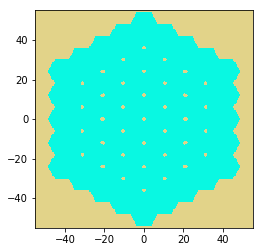

In [ ]:
hex_cell = openmc.Cell(name='fuel disk')
hex_cell.fill = hexag

# Create final universe
uni = openmc.Universe(name='uni')
uni.add_cell(hex_cell)
#uni.region = -outer_bound & +f_lower_surf & -m_upper_surf


uni.plot(width=(2.2*disk_outer, 2.2*disk_outer), origin = (0,0,(fuel_depth+ref_depth)/2), basis='xy', color_by='material')

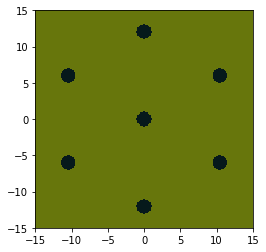

In [ ]:
#zoom in
uni.plot(width=(5*hex_dis, 5*hex_dis), basis='xy', color_by='material')

In [ ]:
uni2 = openmc.Universe(cells=[f, m_per, m2_per, v])

In [ ]:
#create root universe
geom = openmc.Geometry()
geom.root_universe = uni2

#configure statistics geometry
#source = openmc.stats.Box((-20, -20, 0), (20, 20, fuel_depth))
source = openmc.stats.Point((fuel_inner+(fuel_outer-fuel_inner)/2, 0, 1))
src = openmc.Source(space=source)

#export geometry
geom.export_to_xml()

In [ ]:
#create materials & cross sections xmls
mats = openmc.Materials()
mats.cross_sections = '/home/james/nndc_hdf5/cross_sections.xml' #comment this out/replace if you need to
mats.append(fuel)
mats += [BeO]
mats += [vac]

#export materials
mats.export_to_xml()

In [ ]:
settings = openmc.Settings()
settings.particles = 1000
settings.batches = 20
settings.inactive = 10
settings.source = src
settings.export_to_xml()

In [ ]:
#configure tallies
cell_filter = openmc.CellFilter(f)
t = openmc.Tally(4)
t.filters = [cell_filter]
t.scores = ['fission']
tallies = openmc.Tallies([t])

#export tallies
tallies.export_to_xml()

In [ ]:
openmc.run()

openmc: Relink `/home/james/anaconda3/bin/../lib/./libgfortran.so.4' with `/lib/x86_64-linux-gnu/librt.so.1' for IFUNC symbol `clock_gettime'

                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               ####################